In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import fbeta_score, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from lightgbm  import LGBMClassifier

from sklearn.model_selection import learning_curve

In [2]:
data = pd.read_csv('../input/spam.csv', encoding = 'ISO-8859-1')
data.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [3]:
data = data.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"],
                         axis = 1)
data.columns = ["Type", "Text"]
data['Type'] = data['Type'].astype('category')
data.head(3)

,Type,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
Type    5572 non-null category
Text    5572 non-null object
dtypes: category(1), object(1)
memory usage: 49.1+ KB


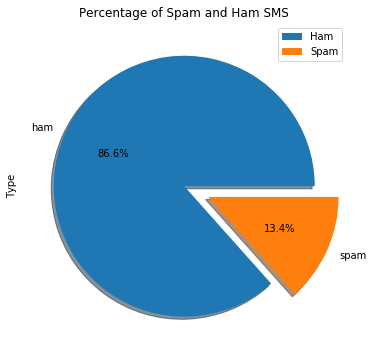

In [5]:
data['Type'].value_counts().plot(kind = 'pie', autopct = '%0.1f%%', explode = [0,0.2], figsize = (6,6), shadow = True)
plt.title("Percentage of Spam and Ham SMS")
plt.legend(["Ham", "Spam"])
plt.show()

In [6]:
from wordcloud import WordCloud
def visualize(label):
    words = ''
    for msg in data[data['Type'] == label]['Text']:
        msg = msg.lower()
        words += msg + ' '
    wordcloud = WordCloud(width=600, height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

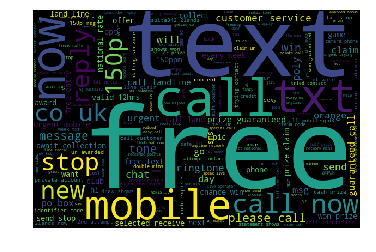

In [7]:
visualize('spam')

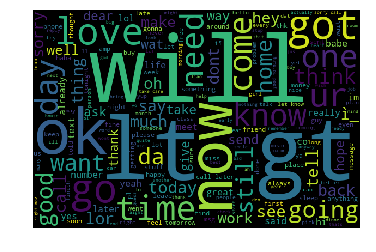

In [8]:
visualize('ham')

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(encoding = 'ISO-8859-1', stop_words='english', decode_error = 'ignore')
X = vectorizer.fit_transform(data['Text'])
print(X.shape)

(5572, 8404)


In [10]:
y = pd.get_dummies(data['Type'], drop_first  = True).values
y = np.reshape(y, ([y.shape[0],]))

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 0, stratify = y)

In [15]:
scoring = {}

def score(model ,X = X, y = y, name = False):
    global scoring
    nameofmodel = str(model.get_params).split('of')[1].split('(')[0].strip()
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(X)
    score = cross_val_score(model, X, y , cv= kf, scoring = 'accuracy')
    if not name:
        scoring[nameofmodel] = [score.mean(), score.std()]
    else:
        scoring[name] = [score.mean(), score.std()]


In [16]:
model1 = MultinomialNB()
score(model1)

model2 = AdaBoostClassifier()
score(model2)

model3 = RandomForestClassifier(n_estimators= 20, random_state = 0)
score(model3)

model4 = DecisionTreeClassifier(random_state=0)
score(model4)

model5 = LogisticRegression(solver = 'lbfgs')
score(model5)

model6 = SVC(kernel = 'rbf', gamma = 'scale')
score(model6, name = 'SVC with rbf kernel')

model7 = SVC(C = 1, kernel = 'linear', gamma = 'scale')
score(model7, name = "SVC with linear kernel")

model8 = SGDClassifier(random_state = 0)
score(model8)

model9 = GradientBoostingClassifier()
score(model9)

model10 = XGBClassifier()
score(model10)

model11 = LGBMClassifier()
score(model11)

model12 = BernoulliNB()
score(model12)


In [17]:
pd.DataFrame.from_dict(scoring, columns = ['Accuracy', 'Std'],orient='index').round(4).sort_values(['Accuracy'], ascending = False)

,Accuracy,Std
SGDClassifier,0.9808,0.0032
LGBMClassifier,0.9797,0.0020
SVC with linear kernel,0.9779,0.0036
RandomForestClassifier,0.9711,0.0030
SVC with rbf kernel,0.9706,0.0023
MultinomialNB,0.9702,0.0045
DecisionTreeClassifier,0.9697,0.0047
AdaBoostClassifier,0.9672,0.0024
GradientBoostingClassifier,0.9618,0.0038
XGBClassifier,0.9569,0.0053


In [34]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone, ClassifierMixin
class StackingAveragedModels(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [35]:
average_model = StackingAveragedModels(base_models= (model7, model3, model8), meta_model=model11)

score(average_model,  name = 'Average_model1')

In [ ]:
average_model2 = StackingAveragedModels(base_models= (model7, model11, model8), meta_model=model12)

score(average_model2, name = 'Average_model2')

In [44]:
pd.DataFrame.from_dict(scoring, columns = ['Accuracy', 'Std'],orient='index').round(4).sort_values(['Accuracy'], ascending = False)

,Accuracy,Std
StackingAveragedModels,0.9817,0.0029
SGDClassifier,0.9808,0.0032
LGBMClassifier,0.9797,0.0020
BernoulliNB,0.9781,0.0043
SVC with linear kernel,0.9779,0.0036
RandomForestClassifier,0.9711,0.0030
SVC with rbf kernel,0.9706,0.0023
MultinomialNB,0.9702,0.0045
DecisionTreeClassifier,0.9697,0.0047
AdaBoostClassifier,0.9672,0.0024


In [46]:
def learning_curves(model):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(X)
    train_sizes, train_scores, validation_scores = learning_curve(estimator = model,X = X,y = y,
                                                                  cv = kf,scoring = 'accuracy')
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('Accuracy', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'LC for a ' + str(model.get_params).split('of')[1].split('(')[0].strip() + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    

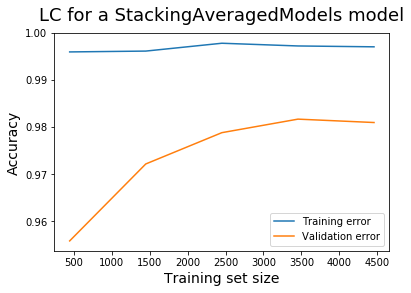

In [38]:
learning_curves(average_model2)

Its **overfitting** 

So what next,<br>
1. Get more training example
2. Try smaller sets of features
3. Alter regularisation parameter